# Reading the netCDF files in Python

*Note: This notebook uses Python 3.*

In this notebook we will explore the interpolated dataset and test some basic python functions.

**Contents**
1. Reading and exploring the data
2. Slicing the data (to do)
3. Computing the CRPS from the raw ensemble (to do)

## 1. Reading and exploring the data

Let's start by opening the file and checking out what data it contains.

In [1]:
from netCDF4 import Dataset
# Define directory where interpolated files are stored.
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # At LMU
# DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
# Define file name
fn = 'data_interpolated.nc'

In [2]:
# Open NetCDF rootgroup 
rg = Dataset(DATA_DIR + 'data_interpolated.nc')

In [3]:
# What does the NetCDF file contain?
rg

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): station(537), member(50), time(7306), nchar(36)
    variables(dimensions): int32 station(station), int32 member(member), int32 time(time), float32 t2m_fc(time,member,station), float32 t2m_obs(time,station), float32 station_alt(station), float32 station_lat(station), float32 station_lon(station), float32 station_id(station), |S1 station_loc(station,nchar)
    groups: 

Here is what's in the file:
- 4 dimensions: station, member, time and nchar
- Variables:
    - station(station) == station_id
    - member(member)
    - time(time) *Time in s since 1.1.1970*
    - t2m_fc(time, member, station)
    - t2m_obs(time, station)
    - station_alt(station) *Altitute of station in m*
    - station_lat(station) *Latitude in degrees*
    - station_lon(station)  *Longitude in degrees*
    - station_id(station) == station
    - station_loc(station, nchar)  *Location name*

So how much training data do we have?

In [4]:
# Total amount of data
rg.dimensions['station'].size * rg.dimensions['time'].size / 2

1961661.0

In [5]:
# Rough data amount per month
rg.dimensions['station'].size * rg.dimensions['time'].size / 2 / 12.

163471.75

In [6]:
# Per station per month
rg.dimensions['time'].size / 2 / 12.

304.4166666666667

Ok, let's now look at some of the variables.

### 1.1 Time

In [7]:
time = rg.variables['time']
time

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1970-01-01 00:00 UTC
    long_name: valid time of forecasts and observations, UTC
unlimited dimensions: 
current shape = (7306,)
filling on, default _FillValue of -2147483647 used

In [8]:
time[:5]

array([1167739200, 1167782400, 1167825600, 1167868800, 1167912000], dtype=int32)

In fact, the time is given in seconds rather than hours.

In [9]:
# convert back to dates (http://unidata.github.io/netcdf4-python/#section7)
from netCDF4 import num2date
dates = num2date(time[:],units='seconds since 1970-01-01 00:00 UTC')
dates[:5]

array([datetime.datetime(2007, 1, 2, 12, 0),
       datetime.datetime(2007, 1, 3, 0, 0),
       datetime.datetime(2007, 1, 3, 12, 0),
       datetime.datetime(2007, 1, 4, 0, 0),
       datetime.datetime(2007, 1, 4, 12, 0)], dtype=object)

So dates are in 12 hour intervals. Which means that since we downloaded 36/48h forecasts: the 12UTC dates correspond to the 36 hour fcs and the following 00UTC dates correspond to the same forecast at 48 hour lead time.

### 1.2 Station variables

Station and station ID are in fact the same and simply contain a number, which does not start at one and is not continuous.

In [10]:
import numpy as np
# Check whether the two variables are equal
np.array_equal(rg.variables['station'][:], rg.variables['station_id'][:])

True

In [11]:
# Then just print the first 5
rg.variables['station'][:5]

array([ 3, 44, 71, 73, 78], dtype=int32)

station_alt contains the station altitude in meters.

In [12]:
rg.variables['station_alt'][:5]

masked_array(data = [202.0 44.0 759.0 340.0 65.0],
             mask = [False False False False False],
       fill_value = nan)

In [13]:
rg.variables['station_loc'][0].data

array([b'A', b'a', b'c', b'h', b'e', b'n', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b''],
      dtype='|S1')

Ahhhh, Aachen :D
So this leads me to believe that the station numbering is done by name.

In [14]:
station_lon = rg.variables['station_lon']
station_lat = rg.variables['station_lat']

In [15]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


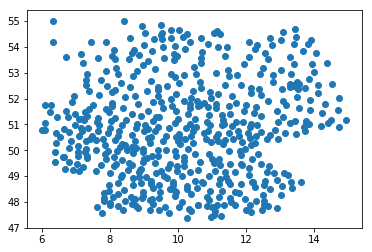

In [16]:
plt.scatter(station_lon[:], station_lat[:])

Wohooo, Germany!

### 1.3 Temperature forecasts and observations

Ok, so now let's explore the temperature data a little.

In [17]:
# Let's extract the actual data from the NetCDF array
# Then we can manipulate it later.
tfc = rg.variables['t2m_fc'][:]
tobs = rg.variables['t2m_obs'][:]

In [18]:
tobs[:5, :5].data

array([[ 5.4000001 ,         nan,         nan,         nan,  5.5999999 ],
       [ 5.5       ,         nan,         nan,         nan,  2.9000001 ],
       [ 6.5999999 ,         nan,         nan,         nan,  5.9000001 ],
       [ 7.19999981,         nan,         nan,         nan,  7.69999981],
       [ 8.80000019,         nan,         nan,         nan,  8.5       ]], dtype=float32)

So there are actually missing data in the observations. We will need to think about how to deal with those.

Sebastian mentioned that in the current version there is some Celcius/Kelvin inconsistencies.

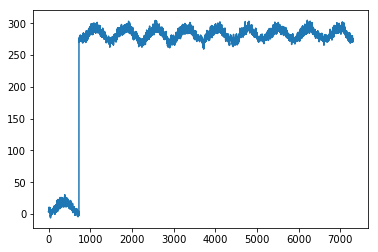

In [19]:
plt.plot(np.mean(tfc, axis=(1, 2)))

In [20]:
# Since this will be fixed soon, let's just create a little ad hoc fix
idx = np.where(np.mean(tfc, axis=(1, 2)) > 100)[0][0]
tfc[idx:] = tfc[idx:] - 273.15

In [21]:
# Let's create a little function to visualize the ensemble forecast
# and the corresponding observation
def plot_fc_obs_hist(t, s):
    plt.hist(tfc[t, :, s])
    plt.axvline(tobs[t, s], c='r')
    plt.title(num2date(time[t], units='seconds since 1970-01-01 00:00 UTC'))
    plt.show()

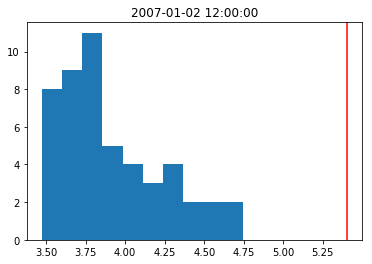

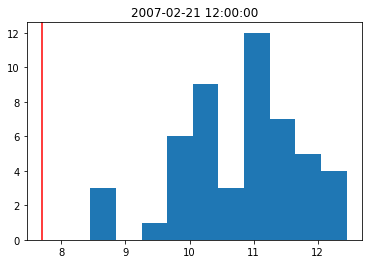

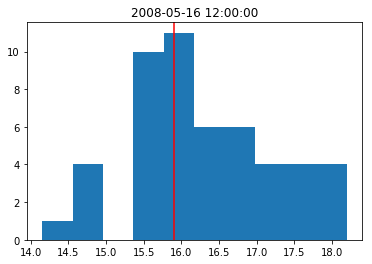

In [22]:
# Now let's plot some forecast for random time steps and stations
plot_fc_obs_hist(0, 0)
plot_fc_obs_hist(100, 100)
plot_fc_obs_hist(1000, 200)

## 2. Slicing the data

Now let's see how we can conveniently prepare the data in chunks for the post-processing purposes.

### 2.1 Monthly slices

The goal here is to pick all data points from a given month and also for a given time, so 00 or 12 UTC

In [23]:
# Let's write a handy function which returns the required data
# from the NetCDF object
def get_data_slice(rg, month, utc=0):
    # Get array of datetime objects
    dates = num2date(rg.variables['time'][:],
                     units='seconds since 1970-01-01 00:00 UTC')
    # Extract months and hours
    months = np.array([d.month for d in list(dates)])
    hours = np.array([d.hour for d in list(dates)])
    
    # for now I need to include the Kelvin fix
    tfc = rg.variables['t2m_fc'][:]
    idx = np.where(np.mean(tfc, axis=(1, 2)) > 100)[0][0]
    tfc[idx:] = tfc[idx:] - 273.15
    
    # Extract the requested data
    tobs = rg.variables['t2m_obs'][(months == 1) & (hours == 0)]
    tfc = tfc[(months == 1) & (hours == 0)]
    return tobs, tfc

In [24]:
tobs_jan_00, tfc_jan_00 = get_data_slice(rg, 1, 0)

In [25]:
tfc_jan_00.shape

(310, 50, 537)

## 3. Compute the parametric and sample CRPS for the raw ensemble data

### 3.1 CRPS for a normal distribution

From Gneiting et al. 2005, EMOS: 

![title](crps_normal.png)


In [26]:
from scipy.stats import norm

In [27]:
def crps_normal(mu, sigma, y):
    loc = (y - mu) / sigma
    crps = sigma * (loc * (2 * norm.cdf(loc) - 1) + 
                    2 * norm.pdf(loc) - 1. / np.sqrt(np.pi))
    return crps

In [28]:
# Get ensmean and ensstd
tfc_jan_00_mean = np.mean(tfc_jan_00, axis=1)
tfc_jan_00_std = np.std(tfc_jan_00, axis=1, ddof=1)

In [29]:
# Compute CRPS using the ensemble mean and variance
crps_jan_00 = crps_normal(tfc_jan_00_mean, tfc_jan_00_std, tobs_jan_00)

/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/s/S.Rasp/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [30]:
# Wanrings probably doe to missing values
crps_jan_00.mean()

1.3547776009326298

Nice, this corresponds well to the value sebastian got for the raw ensemble in January.

### 3.2 Sample CRPS

For this we use the scoringRules package inside enstools.

In [31]:
import sys
sys.path.append('/home/s/S.Rasp/repositories/enstools/')
import enstools

In [32]:
??enstools.scores.crps_sample

In [33]:
tfc_jan_00.shape

(310, 50, 537)

In [36]:
tobs_jan_00.shape

(310, 537)

In [52]:
tfc_jan_00_flat = np.rollaxis(tfc_jan_00, 1, 0)
tfc_jan_00_flat.shape

(50, 310, 537)

In [53]:
tfc_jan_00_flat = tfc_jan_00_flat.reshape(tfc_jan_00_flat.shape[0], -1)
tfc_jan_00_flat.shape

(50, 166470)

In [54]:
tobs_jan_00_flat = tobs_jan_00.ravel()

In [63]:
mask = tobs_jan_00_flat.mask
tobs_jan_00_flat_true = np.array(tobs_jan_00_flat)[~mask]
tfc_jan_00_flat_true = np.array(tfc_jan_00_flat)[:, ~mask]

In [64]:
np.isfinite(tobs_jan_00_flat_true)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [65]:
tfc_jan_00_flat_true.shape

(50, 152109)

In [66]:
enstools.scores.crps_sample(tobs_jan_00_flat_true, tfc_jan_00_flat_true, mean=True)

1.3615713879597848